In [2]:
%matplotlib notebook

import numpy as np
import cv2
import os
import csv

from math import ceil
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from scipy import signal
from sklearn.linear_model import TheilSenRegressor
from mpl_toolkits.mplot3d import Axes3D

In [3]:
'''
Gaussian Filter for 1D

'''
def gauss(m, sigma, x):
    return np.exp(-0.5 * np.power((x-m/2),2) / sigma * np.sqrt(2 + np.pi))

In [4]:
def show_normalized_img(img):
    tmp = img
    tmp -= np.amin(tmp)
    tmp = (tmp / np.amax(tmp)) * 255
    tmp = cv2.applyColorMap(np.uint8(tmp), cv2.COLORMAP_JET)
    
    plt.imshow(tmp, 'gray')
    plt.show()

In [5]:
def build_dog_kernel(kernel, sigma, point_one, point_two, kernel_width, cov_matrix):    
    for i in range(kernel_width):
        for j in range(kernel_width):
            diff_one = np.linalg.norm(point_one - np.transpose([i, j]))
            diff_two = np.linalg.norm(point_two - np.transpose([i, j]))
           
            kernel[j,i] =  gauss(0, sigma, diff_one) - gauss(0, sigma, diff_two)
    
    return kernel

In [6]:
def build_dog_kernel_elipse(kernel, point_one, point_two, kernel_width, cov_matrix):    
    for i in range(kernel_width):
        for j in range(kernel_width):
           
            kernel[j,i] =  multivariate_normal.pdf(point_one, mean=[i,j], cov=cov_matrix) \
                            -  multivariate_normal.pdf(point_two, mean=[i,j], cov=cov_matrix)

    return kernel

In [7]:
'''
Build a rotation Vector by reference of the given angle
'''
def build_rotation_vector(angle):
    rot = np.transpose([np.cos(angle), np.sin(angle)]) #Vector cos and sin of direction angle 
    #print(rot)
    return rot #Flip Vector 

In [8]:

'''
Prepares the given Data to create a DoG kernel
'''
def get_dog_kernel(direction, dist_mean, sigma, kernel_width, cov_matrix):
    kernel = np.zeros(shape=(kernel_width, kernel_width))
    
    center = [int((kernel_width) / 2), int((kernel_width) / 2)]
    
    direction = np.radians(direction) #direction * pi / 180
    avg_route = (dist_mean / 2)    #Length
    
    
    rot = build_rotation_vector(direction)
    
    
    rotation_matrix = np.matrix([[np.cos(direction), np.sin(direction)],[-np.sin(direction), np.cos(direction)]])
    #print(rotation_matrix)
    
    cov_matrix =  rotation_matrix * cov_matrix * np.transpose(rotation_matrix)
    
    
    rot = avg_route * np.transpose([rot[1], rot[0]]) #Multiply with half of the distance 
    rot_two = -rot #negate the vector to get the mirrored point
    
    point_one = rot + center #add to center to move in the right direction
    
    point_two = center + rot_two #add to center to move in the right direction

    #return build_dog_kernel(kernel, sigma, point_one, point_two, kernel_width, cov_matrix)
    return build_dog_kernel_elipse(kernel, point_one, point_two, kernel_width, cov_matrix)

In [9]:
def get_frame_differences(first_frame, sec_frame):
    return first_frame.astype(float) - sec_frame.astype(float)

In [10]:
def get_mean_val_from_neighbour(array, mean_val, angles):
    for i in range (1, len(array) - 1):
        value = (array[i-1] + array[i+1]) / 2
        mean_val.append((angles[i], value))

In [11]:
def read_csv(path):
    angle = 0
    
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            angle = row['Angle']
    
    return float(angle) 

In [12]:
#angles = [-5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75, -80, -85, -90, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
angles = np.arange(0, 360, 1)

angles.sort()

maxima = []
mean_val = []

cov_matrix = np.matrix([[6., 0],[0, 2.]])

smothing = np.matrix([[1,1,1],[1,1,1],[1,1,1]]) / 9

path = '/home/sascwitt/Projects/test/WDs/'
folders = os.listdir(path)
folders.sort()



In [13]:
diff_img = {}

for folder in folders:
    tmp_path = path + folder
    wd_runs = os.listdir(tmp_path)
    
    for run in wd_runs:
        cap = cv2.VideoCapture(tmp_path + '/' +  run + '/' + 'image_%3d.png')

        frame_counter = 0
        last_frame   = None
        image_array = []
    
        run_len = len(os.listdir(tmp_path + '/' +  run + '/'))
        
        run_end =  run_len - int(run_len * 0.1)
    
        while(True):
            ret, frame = cap.read()
            frame_counter += 1
            key = str(tmp_path + '/' +  run + '/')
            
            if (ret == True):
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    
                if last_frame is None:
                    last_frame  = frame
                    continue

                else:
                    frame_diff = get_frame_differences(last_frame, frame)
                    frame_diff = cv2.filter2D(frame_diff, -1, smothing)
                    
                    
                    if (key not in diff_img):
                        diff_img[key] = [frame_diff]
                    
                    else:
                        diff_img[key].append(frame_diff)

                if frame_counter > run_end:
                    ret = False
                
                last_frame = frame
            
            else:
                break


In [14]:
%load_ext line_profiler

In [15]:
kernels = []

for angle in angles:
    kernels.append(get_dog_kernel(angle, 7, 2, 13, cov_matrix))


In [16]:
def calculate_image_sum_for_angle(angles, key, img_arrays):
    sums = []
    
    for idx, angle in enumerate(angles):
        img_sum = 0    
        kernel = kernels[idx]
        
        for index, img in enumerate(img_arrays):
            if (index < len(img_arrays) - 10):
                filtered_img = np.amax(cv2.filter2D(img, -1, -kernel))
        
                img_sum += filtered_img
            else:
                break
                
        sums.append(img_sum)

    return sums, key

In [17]:
def calculate_image_sum_for_frame(_angles, key, img_arrays):
    mat = np.zeros((len(img_arrays), ceil(len(_angles) / 2)))
    
    for index, img in enumerate(img_arrays):      
        for idx in range(int(len(_angles) / 2)):
            kernel = kernels[idx]
        
            mat[index][idx] = np.amax(abs(cv2.filter2D(img, -1, -kernel)))

    return mat, key

In [18]:
img_list = Parallel(n_jobs=-1, verbose=11)(delayed(calculate_image_sum_for_frame)(angles, key, img_arrays) for key, img_arrays in diff_img.items())

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.1s
[Paralle

In [24]:
keys = []
images = []

for img in img_list:
        images.append(img[0])
        keys.append(img[1])

<IPython.core.display.Javascript object>


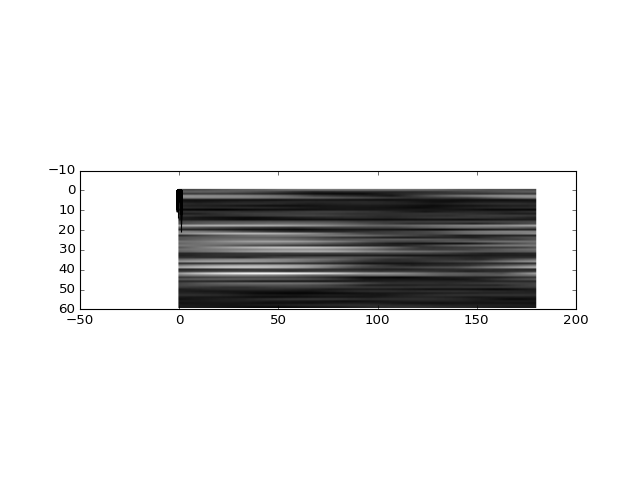

In [25]:
plt.imshow(images[0], 'gray')
plt.show()

In [22]:
keys = []


#print("B")



In [26]:
a = read_csv(keys[1] + 'result.csv') % 360

if a > 180:
    a -= 180

    
ta = np.median(images[1])

pa = np.arctan2(np.sin(a - ta), np.cos(a - ta))

print(pa)

    
est = TheilSenRegressor()
est.fit(np.arange(0, len(images[1]))[:,np.newaxis], images[1].argmax(axis=1))
C = est.predict(np.arange(0,len(images[1]))[:,np.newaxis])


0.488349722837


/home/sascwitt/Projects/test/WDs/20160814_1001_1/1/
38.7741709356
54.0


<IPython.core.display.Javascript object>


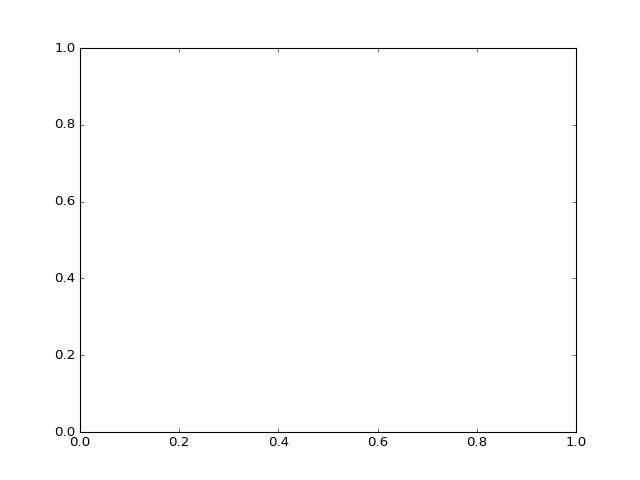

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 60 x 180)
  '(shape is %d x %d)' % inp.shape[::-1])


ValueError: weights should have the same shape as x

In [30]:



for index, i in enumerate(images):
    a = read_csv(keys[index] + 'result.csv') % 360
        
    if a > 180:
        a -= 180

    print(keys[index])
    print(a)
    #print(np.median(i.argmax(axis=1)))
    
    est = TheilSenRegressor()
    maximum = i.argmax(axis=1)
    est.fit(np.arange(0, len(i))[:,np.newaxis], maximum)
    print(np.median(maximum))
    
    cos = []
    sin = []
    
    for m in maximum:
        cos.append(np.cos(m))
        sin.append(np.sin(m))
    
    
    
    #cos_sin_mat = np.array([[cos], [sin], [leng]])
   
    fig = plt.figure()
    
    
    
    plt.hist(cos, bins=100, weights=i)
    #plt.plot(est.predict(np.arange(0,len(i))[:,np.newaxis]), "y", lw=2)
    #plt.plot([0, len(i)], [a, a], 'k-', lw=2)
    #plt.imshow(np.rot90(i, 3))
    plt.show()
    

print(a)







<IPython.core.display.Javascript object>


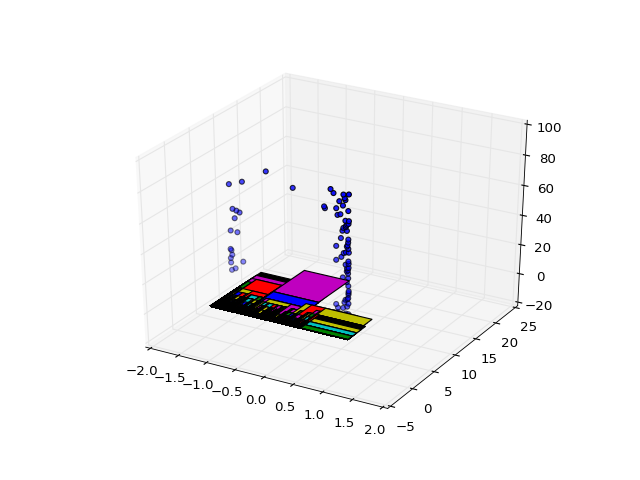

[156  41  17  90 175 176  32  90  90 140 174  49  48  44  45  39  22   0
  39  29  42  17  61  26   0  23  16  11 173 161   0   0   4 177 146  11
 178  19 170  30  12 173 178  13  19  14  18   9  23  42   0  11  33 155
 174  28  22   5  42  12  19  16 160  13  34  12 150 156 165  31  19  29
  23  22  18  11  24   6  40  35  57  58  42  13 177  30 145  37  90  24
  26  46  29  50   0 116]


In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

leng = np.arange(len(images[0]))
    
maximum = images[0].argmax(axis=1)

print(maximum)

cos = []
sin = []
    
for m in maximum:
    cos.append(np.cos(np.radians(angles[m])))
    sin.append(np.sin(np.radians(angles[m])))
    

for x, y, z in [(cos, sin, leng)]:
    xs = x
    ys = y
    zs = z
    ax.scatter(xs, ys, zs)
plt.show()

In [27]:
print(len(img_list))
error_two = []

for index, img in enumerate(images):
    gt_angle = read_csv(keys[index] + 'result.csv') % 360
     
    if gt_angle > 180:
        gt_angle -= 180
        
        
    error_two.append(np.median(img.argmax(axis=1)) - gt_angle)

plt.hist(error_two, bins=100)
print(len(error_two))
print("calc mean: ", np.median(error_two))
print("calc std: ", np.std(error_two))

100
100
calc mean:  11.8108133581
calc std:  32.7380899582


def calculate_image_sum_for_angle(angles, key, img_arrays):
    sums = []
    
    for idx, angle in enumerate(angles):
        img_sum = None    
        kernel = kernels[idx]
        
        for img in img_arrays:
            filtered_img = cv2.filter2D(img, -1, -kernel)
        
            if img_sum is None:
                img_sum = abs(filtered_img)
                 
            else:
                img_sum = cv2.add(img_sum, abs(filtered_img))
    
        sums.append(cv2.filter2D(img_sum, -1, smothing))

    return sums, key

In [ ]:
sums = Parallel(n_jobs=-1, verbose=11)(delayed(calculate_image_sum_for_angle)(angles, key, img_arrays) for key, img_arrays in diff_img.items())

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.5s
[Paralle

In [77]:
maxima = []


for i in sums:
    img_sum = np.array(i[0])
    maximum = np.unravel_index(img_sum.argmax(), img_sum.shape)
    maxima.append((maximum[0], i[1]))

tmp = 0
tmp_idx = 0


(106,)


(92,)
(92,)


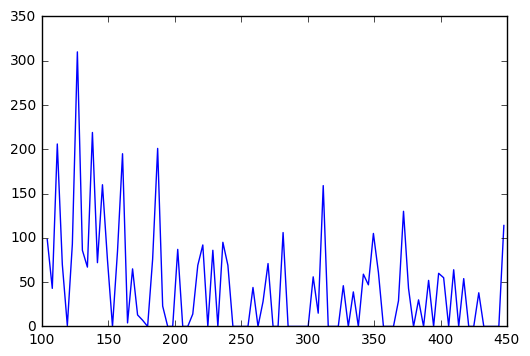

[118.94406872748544, 117.82754623635959, 107.98462428081876, 124.02956158837651, 164.39685718530637, 142.30154242769606, 135.60318156501958, 176.3922730034912, 143.76407799681522, 229.77967715762998, 104.37479455090146, 190.61849787783666, 192.25219566958776, 172.91198974818744, 215.34370647434449, 306.42475171036529, 168.53330735542733, 111.81549892501421, 128.38601581320793, 219.27968127770745, 310.61016840548484, 270.44882892334749, 142.32121926251483, 143.67776189232112, 146.83567644990183, 340.95873438381085, 352.65778926405352, 239.1410199441143, 264.96266953316353, 370.02003538073859, 381.90548372050029, 159.17499547834439, 127.56017740041672, 237.55450455095965, 340.74441573011228, 354.0128915358984, 113.1184080527235, 349.0269801744011, 427.64099268163108, 335.44401430153334, 146.46120366231665, 106.74134883411118, 240.1311756283279, 377.01853529341133, 260.57253742323689, 140.16850316051142, 325.73370790559579, 345.20701276424262, 281.7014425536218, 167.56632610307506, 269.23

In [162]:
tmp = np.array([])

#print(np.array(sums)[0].shape)

leng = np.array(diff_img[sums[0][1]])

x = len(leng)

t = np.arange(0, x)

print(t.shape)
print(np.array(sums[0][0]).shape)

y,binEdges=np.histogram(sums[0][0],bins=x, weights=t)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.show()

#plt.hist(, bins=x, )
print(sums[0][0])

In [68]:

for idx, val in enumerate(maxima):
    #print(angles[tmp_idx] - read_csv(tmp_path + '/' +  run + '/'  + 'result.csv'))
    gt_angle = read_csv(val[1] + 'result.csv')
    test_angle = 0
    
    test_angle = (angles[val[0]] - gt_angle)
    
    
    #if (gt_angle > 0):
    #    test_angle = (angles[val[0]] - gt_angle)
      
    #else:
        #test_angle = (angles[val[0]] + gt_angle)
        
        
    

In [69]:
error = []
for idx, val in enumerate(maxima):
    #print(angles[tmp_idx] - read_csv(tmp_path + '/' +  run + '/'  + 'result.csv'))
    gt_angle = read_csv(val[1] + 'result.csv')
    test_angle = 0
    tt = 0
    
    if gt_angle < 0:
        gt_angle = gt_angle % 360
    
    test_angle = (angles[val[0]] - gt_angle)
    
    error.append(test_angle)

lt 185.608468853
gt 171.559620478
gt 173.55604522
lt 191.931417178
lt 204.758650348
lt 186.341089937
lt 190.552263673
lt 197.231711068
lt 186.030389606
gt -185.304846469
gt 163.298570331
lt 184.464932842
gt -184.418055345
lt 180.972626615
lt 190.118596003
gt -193.40782459
lt 193.114834886
lt 192.380135052
lt 188.495733281
gt -187.750966993
gt -196.179620448
lt 190.273689006
lt -169.039063866
gt -186.36704926
gt 175.004920871
lt 190.762632887
lt 190.945395901
lt 188.009005957
gt 117.035512899
gt -188.217969577
gt -183.699244234
lt 192.225829064
lt -166.751173664
gt 168.510447078
lt 195.521361835
lt 195.53076561
gt 176.298645395
lt 208.237608976
lt 187.820991974
lt 192.603091194
lt 185.676393137
lt -167.157475739
gt -199.366460663
lt -159.763641691
gt -181.144623741
lt 195.663140708
lt 193.474431626
lt 182.309932474
lt 189.068582822
lt 185.898901839
lt -165.412306618
lt 198.0
lt -177.763605201
lt -149.300277449
lt 186.927513064
lt 191.072486936
lt 188.565051177
lt 197.758085653
lt -170.3

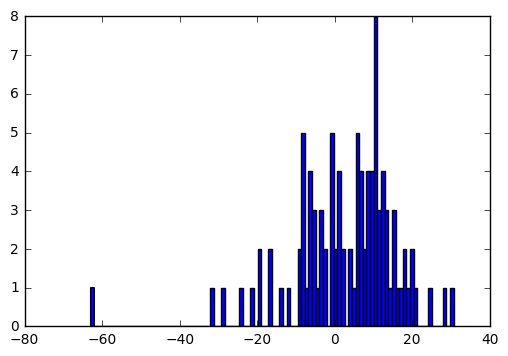

In [70]:
cp = 0
cn = 0

for idx, i in enumerate(error):
    
    if i > 180:
        error[idx] = i - 360
    
    if i < -180:
        error[idx] = i + 360
        
    if error[idx] > 90:
        print("gt", i)
        cp += 1
        error[idx] -= 180
        
    if error[idx] < -90:
        cn += 1
        print('lt', i)
        error[idx] += 180
        
    
print(cn, cp, cn + cp)   
print("calc mean: ", np.mean(error))
print("calc std: ", np.std(error))


#plt.figure() 
plt.hist(error, bins=100)
#plt.savefig()

cap.release()
cv2.destroyAllWindows()

In [21]:
def get_max_pos():
        pass

maxi_total = []

    
def get_image_maxima():
    for val in maxima:
        kernel = kernels[val[0]]
              
        pos_sum = [0, 0]
        last_sum = [0, 0]
        dir_fit = 0
            
        for index, img in enumerate(diff_img[val[1]]):
            array_len = len(diff_img[val[1]]) / 2 
            
            filtered_img = cv2.filter2D(img, -1, -kernel)
        
            if (index <= array_len):
                x, y = np.unravel_index(filtered_img.argmax(), filtered_img.shape)
                pos_sum = (pos_sum[0] + x, pos_sum[1] + y)
                
            elif (index >= array_len - 10):
                last_sum = (last_sum[0] + x, last_sum[1] + y)
                
        pos_sum = (pos_sum[0] / (array_len), pos_sum[1] / (array_len))
        #last_sum = (last_sum[0] / 10, last_sum[1] / 10)
            
        #res = [pos_sum[0] - last_sum[0], pos_sum[1] - last_sum[1]]
            
        angle_pos = np.array([np.cos(angles[val[0]]) * np.pi / 180, np.sin(angles[val[0]]) * np.pi / 180])
        inverse = -angle_pos
            
        direction = np.dot(pos_sum, angle_pos)
        inverse_dir = -direction
    
       
        if direction >= 0 or direction == -0.0:
            dir_fit = angles[val[0]]
        
        else:
            dir_fit = -(-angles[val[0]] % 360)
        
        maxi_total.append([dir_fit, val[1]])


In [22]:
get_image_maxima()

In [23]:
ct = 0
cc = 0
e = 0

for val, k in maxi_total:
    ang = read_csv(k  + 'result.csv')
    
    if (ang <= 0 and val <= 0):
        ct += 1
    
    elif (ang > 0 and val > 0):
        ct += 1
 
    else:
        e += 1
    print(val)#print(ang, val, k)

-130
182
-167
-338
-155
-141
197
196
-343
12
32
-179
333
247
-161
-149
-274
33
-179
-257
202
228
-336
-149
-142
-162
-142
75
358
-275
39
182
-181
-274
189
14
233
12
208
46
-10
346
-286
-300
221
-193
227
-24
215
208
202
0
359
-130
215
203
-141
213
70
-168
197
12
-129
208
-135
177
-274
-288
-311
351
31
202
-11
221
-336
-160
1
360
-318
-148
183
246
-345
13
-326
-267
-343
-336
151
-149
-9
358
-161
12
197
197
-5
32
31
-155


In [117]:
print(ct, cc, e)

35 23 42


In [ ]:
%lprun -f get_image_maxima get_image_maxima()
#ToDO Maxima Checken ob das Richtige Maximum gefunden wurde 
# Maximum stimmt
#mean auf 0 
# std auf 0


In [ ]:
class DoG_Kernel:
    _dog_kernel       = []
    _dog_kernel_width = 0
    _dog_covariance_matrix = []
    _dog_kernel_center = 0

    def __init__(kernel_width, cov_matrix):
        self._dog_kernel = np.zeros(shape=(kernel_width, kernel_width))
        self._dog_kernel_width = kernel_width
        self._dog_covariance_matrix = cov_matrix
        self._dog_kernel_center = [ceil(kernel_width / 2), ceil(kernel_width / 2)]
    
    
    '''
    Prepares the given Data to create a DoG kernel
    '''
    def get_dog_kernel(direction, distance, sigma, dog_type=0):
        direction = np.radians(direction) #direction * pi / 180
        average_distance = (distance / 2)    #Length
    
        rotated_direction_positive = average_distance * np.array([-np.sin(angle), np.cos(angle)]) 
        rotated_direction_negative = -rotated_direction_positive
    
        rotation_matrix = np.matrix([[np.cos(direction), np.sin(direction)],[-np.sin(direction), np.cos(direction)]])
    
        rotateted_covariance_matrix = rotation_matrix * self._dog_covariance_matrix * np.transpose(rotation_matrix)
    
        mean_positive = rotated_direction_positive + center #add to center to move in the right direction
        mean_negative = rotated_direction_negative + center #add to center to move in the right direction
    
        if (dog_type == 0):
            return build_circle(mean_positive, mean_negative, sigma)
        elif (dog_type == 1):
            return build_elipse(mean_positive, mean_negative)
        
    def build_elipse(point_one, point_two):    
        tmp_kernel = self._dog_kernel
        
        for y in range(self._dog_kernel_width):
            for x in range(self._dog_kernel_width):
           
                tmp_kernel[y, x] =  multivariate_normal.pdf(point_one, mean=[i,j], cov=self._dog_covariance_matrix) \
                                    -  multivariate_normal.pdf(point_two, mean=[i,j], cov=self._dog_covariance_matrix)

        return tmp_kernel
    
    def build_circle(point_one, point_two, sigma):
        tmp_kernel = self._dog_kernel
        
        for y in range(self._dog_kernel_width):
            for x in range(self._dog_kernel_width):
                diff_one = np.linalg.norm(point_one - np.transpose([i, j]))
                diff_two = np.linalg.norm(point_two - np.transpose([i, j]))
           
                tmp_kernel[j,i] =  gauss_1d(0, sigma, diff_one) - gauss_1d(0, sigma, diff_two)
        
        return tmp_kernel
    
    '''
    Gaussian Filter for 1D

    '''
    def gauss_1d(mean, sigma, x):
        return np.exp(-0.5 * np.power( (x-mean / 2), 2) / sigma * np.sqrt(2 + np.pi))

In [ ]:
class Image_operations:
    
    def get_frame_differences(first_frame, sec_frame):
        return first_frame.astype(float) - sec_frame.astype(float)
    
    def show_normalized_img(img):
        tmp = img
        tmp -= np.amin(tmp)
        tmp = (tmp / np.amax(tmp)) * 255
        tmp = cv2.applyColorMap(np.uint8(tmp), cv2.COLORMAP_JET)
    
        plt.imshow(tmp, 'gray')
        plt.show()

In [63]:
img_sum2 = None
for folder in folders:
    tmp_path = path + folder
    wd_runs = os.listdir(tmp_path)
    
    for run in wd_runs:
        for angle in angles:
            cap = cv2.VideoCapture(tmp_path + '/' +  run + '/' + 'image_%3d.png')
            #ENTER KERNEL SIZE AND STUFF HERE!
            kernel = get_dog_kernel(i, 5, 10, 11, cov_matrix)
            #print(i)
            #plt.imshow(kernel, interpolation='nearest')
            #plt.show()

            while(True):
                ret, frame = cap.read()
                frame_counter += 1

                if (ret == True):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                    if last_frame is None:
                        last_frame  = frame
                        continue

                    else:
                        frame_diff = get_frame_differences(last_frame, frame)
                        frame_diff = cv2.filter2D(frame_diff, -1, smothing)
                        frame_diff = cv2.filter2D(frame_diff, -1, -kernel)

                        if img_sum2 is None:
                            img_sum2 = abs(frame_diff)

                        else:
                            img_sum2 = cv2.add(img_sum2, abs(frame_diff))

                        #frame_diff = cv2.applyColorMap(np.uint8(frame_diff), cv2.COLORMAP_JET)

                        last_frame = frame


                        #plt.show()
                        #plt.imshow(frame_diff, 'gray')

                else:
                    test = 0 
                    
                    #np.set_printoptions(threshold=np.inf)
                    #print(img_sum)
                    #for x in range(len(img_sum2)):
                     #   for y in range (len(img_sum2)):
                      #      if img_sum[y][x] < 0.001:
                       #         counter += 1

                    frame_diff = cv2.filter2D(img_sum2, -1, smothing)

                    maximum = np.amax(img_sum2)

                    #test = img_sum.max(0)
                    #test2 = img_sum.max(1)

                   # test_2 = 
                    #t = 0
                    #for idx, p in enumerate(test):
                        #t += p 

                    #for p in test_2:
                     #   t += p

                    #print(t)
                    #for i in range(len(img_sum) - 1):
                    #    for j in range(len(img_sum) - 1):
                    #       maximum += img_sum[i][j]
                    #print("val below 1: ", counter)
                    #maxima.append(maximum)
                    maxima.append(maximum)
                    break

        tmp = 0
        tmp_idx = 0

        for idx, val in enumerate(maxima):
            if tmp < val:        
                tmp = val
                tmp_idx = idx 

        #print(angles[tmp_idx] - read_csv(tmp_path + '/' +  run + '/'  + 'result.csv'))
        test_angle = (angles[tmp_idx] - read_csv(tmp_path + '/' +  run + '/'  + 'result.csv'))
      
        error.append(test_angle)
        
        maxima = []
        
        
#for key, img_arrays in diff_img.items():
    #for angle in angles:
    #    img_sum = None
   #     
  #      for img in img_arrays:
 #           kernel = get_dog_kernel(angle, 7, 10, 11, cov_matrix)
#
     #       filtered_img = cv2.filter2D(img, -1, -kernel)
    #        counter += 1
   #         if img_sum is None:
  #              img_sum = abs(filtered_img)
 #                
 #           else:
#                img_sum = cv2.add(img_sum2, abs(filtered_img))

#        img_sum = cv2.filter2D(img_sum2, -1, smothing)

#        maximum = np.amax(img_sum)
#        maxima.append(maximum)

    #tmp = 0
    #tmp_idx = 0

    #for idx, val in enumerate(maxima):
    #    if tmp < val:        
    #        tmp = val
    #        tmp_idx = idx 

    #print(angles[tmp_idx] - read_csv(tmp_path + '/' +  run + '/'  + 'result.csv'))
    #test_angle = (angles[tmp_idx] - read_csv(key + 'result.csv'))
      
    #error.append(test_angle)
        
    #maxima = []

TypeError: unorderable types: int() < tuple()